# BBC News Classification

### Project Introduction

This project explored classifying BBC news articles into their respective categories: sport, business, politics, entertainment, and tech. This work was ran on Google Colab, where I leveraged both unsupervised and supervised machine learning approaches. The following steps were taken:

1. Load & Preprocess Data: Started by cleaning and preparing the news articles.
2. Unsupervised NMF: Performed topic modeling with Non-negative Matrix Factorization to see how the data clusters without labels.
3. Supervised Models:
  - Logistic Regression and Multinomial Naïve Bayes were trained on TF-IDF features to compare their performance in classifying the articles.
  - Submission files were generated for the “Learn AI BBC” Kaggle competition.
4. Further Optimizations with BERT: Finally, I fine-tuned a BERT model, significantly boosting accuracy and achieving a top score on Kaggle.

By following this process, from NMF to classical supervised methods and then modern Transformers, I gained a comprehensive view of how various NLP techniques perform on the BBC News dataset. References and sources for the methods are provided at the end of this notebook.



##  Necessary Libraries



In [1]:
# !pip install contractions
# !pip install datasets
# !pip install evaluate

In [2]:
# essential libraries
import numpy as np
import pandas as pd
import warnings
from itertools import permutations

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# text preprocessing and NLP
import re
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# dl necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# feature extraction and vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# dimensionality reduction
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# model eval and metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, adjusted_mutual_info_score)

# model selection and pipelines
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV, ParameterGrid)
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewgraham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewgraham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the Data and Visualizing
Adjust file paths as needed


In [6]:
df_train = pd.read_csv("../data/BBC News Train.csv")
df_test = pd.read_csv("../data/BBC News Test.csv")
sample_solution_df = pd.read_csv("../data/BBC News Sample Solution.csv")

df_train['category_id'] = df_train['Category'].factorize()[0]
category_id_df = df_train[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

### Displaying Data Information


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [8]:
print(sample_solution_df)

     ArticleId       Category
0         1018          sport
1         1319           tech
2         1138       business
3          459  entertainment
4         1020       politics
..         ...            ...
730       1923          sport
731        373           tech
732       1704       business
733        206  entertainment
734        471       politics

[735 rows x 2 columns]


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ArticleId    1490 non-null   int64 
 1   Text         1490 non-null   object
 2   Category     1490 non-null   object
 3   category_id  1490 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.7+ KB


In [10]:
df_train.head()

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [11]:
df_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### Displaying Unique Values and Missing Data



In [12]:
print(df_train.columns)

Index(['ArticleId', 'Text', 'Category', 'category_id'], dtype='object')


In [13]:
# check what unique values exist in each Category to confirm number of distinct categories
df_train['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [14]:
missing_data = df_train.isnull().sum() / len(df_train) * 100

print("Here is the missing data:")
print(missing_data.sort_values(ascending=False))

Here is the missing data:
ArticleId      0.0
Text           0.0
Category       0.0
category_id    0.0
dtype: float64


### Count Plots:
Count plots were used to visaulize the dsitribution of news categories in order to look for class imbalances. Each news category looks similar in count, so we do not have any large class imbalances.


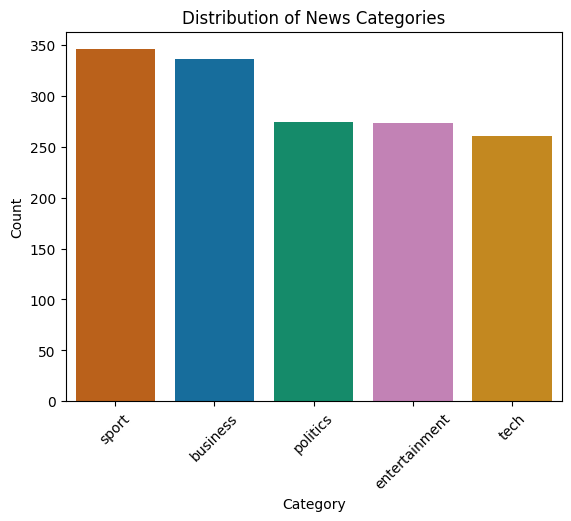

In [17]:
# unique color for each category
unique_categories = df_train['Category'].value_counts().index

# count plot for 'Category'
sns.countplot(data=df_train,
              x='Category',
              order=unique_categories,
              hue='Category',
              palette='colorblind',
              legend=False)

plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Feature Relationships:

Histograms were plotted to investigate numerical features like the distribution of text lengths. While there appear to be a few outliers of very long text, the vast majority are 1700 characters, so I will leave all articles in the model.



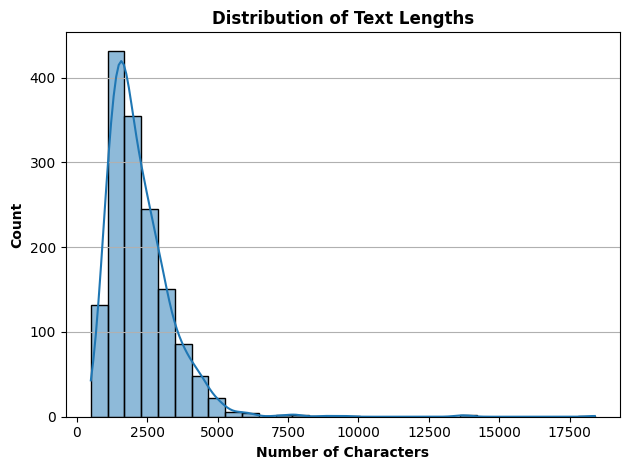

In [24]:
# add a column for text lengths
df_train['text_length'] = df_train['Text'].apply(len)

# plot histogram of text lengths
sns.histplot(data=df_train, x='text_length', bins=30, kde=True)
plt.title('Distribution of Text Lengths', fontweight='bold')
plt.xlabel('Number of Characters', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Word Clouds:
Word Clouds were used to easily visualize the most common words in the training data before the text was cleaned. This aided in the text cleaning process by allowing me to see which type of words need to be removed. It is clear that stopwords will need to be removed from this.

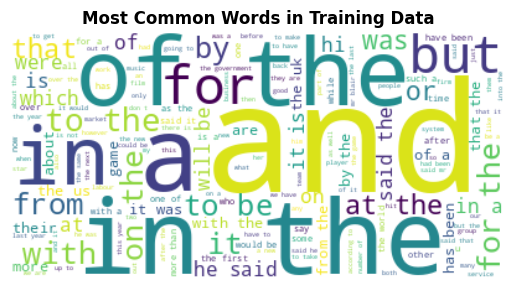

In [25]:
# combine all text for word cloud
text_data = " ".join(df_train['Text'].tolist())
wordcloud = WordCloud(stopwords="english", background_color="white").generate(text_data)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Words in Training Data', fontweight='bold')
plt.show()

### Data Cleaning
In order to enhance the data quality for more predictive power, improve the efficiency of our models, and standardize the inputs to remove biases, text cleaning was performed. First, punctuation was removed to get rid of special characters allowing me to focus on meaningful text content. Next, numbers were removed because they don't contribute meaningfully to text analysis. Then, common contractions (like "can't" into "cannot") were removed to maintain consistency. Lowercasing was used to make all of the text lowercase to avoid case sensitivity issues. Next, stopwords were removed to get rid of frequently occurring words like "the", "is", or "and" that provide little semantic and predictive value. Lastly, lemmatization was used to reduce words to their base form (like "running" to "run"), which helps reduce dimensionality.





In [26]:
# CITATIONS:
# "contractions" for expanding typical English contractions,
# "WordNetLemmatizer" from NLTK for lemmatization,
# "stopwords.words('english')" from NLTK.
# more citations for NLP methods are found at the end of the notebook :)

def text_cleaning(df, text_col, custom_stopwords=None):

    lemmatizer = WordNetLemmatizer()

    # remove punctuation
    df['no_punct'] = df[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', str(row)))

    # remove numbers
    df['no_punct_num'] = df['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))

    # expand contractions
    df['no_contractions'] = df['no_punct_num'].apply(lambda row: contractions.fix(row))

    # convert to lowercase
    df['lowercase'] = df['no_contractions'].apply(lambda row: row.lower())

    # prepare stopwords
    default_stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        # add any user supplied custom stopwords
        default_stop_words.update(custom_stopwords)

    # remove stopwords
    df['no_stopwords'] = df['lowercase'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in default_stop_words])
    )

    # lemmatize
    df['clean_text'] = df['no_stopwords'].apply(
        lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
    )

    # drop intermediate columns to keep dataframe clean
    df.drop(['no_punct', 'no_punct_num', 'no_contractions', 'lowercase', 'no_stopwords'], axis=1, inplace=True)

    return df


In [27]:
extra_stopwords = ["said", "say", "also", "would", "could", "one"]

# clean text data in training data
df_train = text_cleaning(df_train, 'Text', custom_stopwords=extra_stopwords)
df_test = text_cleaning(df_test, 'Text', custom_stopwords=extra_stopwords)

In [28]:
# to check that clean_text is present
print(df_train.columns)

Index(['ArticleId', 'Text', 'Category', 'category_id', 'text_length',
       'clean_text'],
      dtype='object')


### Check the result of text cleaning

In [29]:
# check for punctuation removal:
print(any(char in df_train['clean_text'][1] for char in "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"))
# check for number removal:
print(any(char.isdigit() for char in df_train['clean_text'][1]))
# check for contraction expansion:
print("it's" in df_train['clean_text'][1])
# check for stopword removal:
stop_words_in_ex = set(stopwords.words('english'))
print(any(word in df_train['clean_text'][1].split() for word in stop_words_in_ex))
# check lemmatization:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("running") in df_train['clean_text'][1])

False
False
False
False
False


From this new word cloud, we can see a few key words pop up that will be very helpful in predicting categories. Words like government, country, game, firm, technology, and film clearly fit into distinct categories.

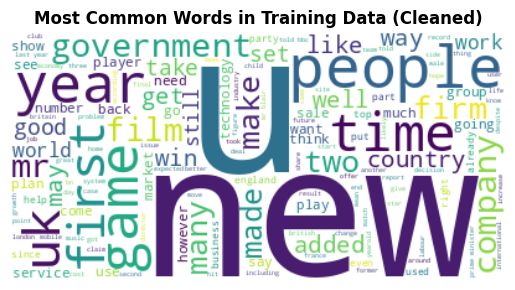

In [30]:
# combine all cleaned text for word cloud
text_data = " ".join(df_train['clean_text'].tolist())
wordcloud = WordCloud(stopwords="english", background_color="white").generate(text_data)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Words in Training Data (Cleaned)', fontweight='bold')
plt.show()

### Token Count Analysis
The number of words in eachc article helps me to detect outliers and see the typical article length. This information is helpful for preprocessing and feature engineering in text based tasks like this. A histogram visualizes the distribution to show any patterns and outliers. Most articles are around 200 words in length and there are not many outliers here so we can include them all.

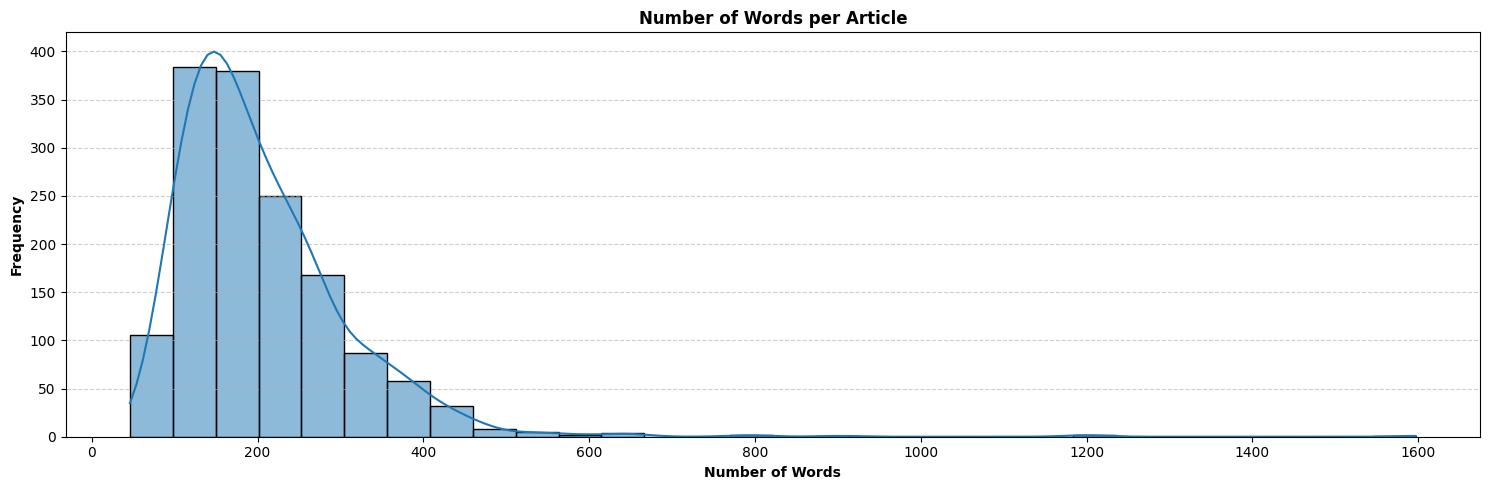

In [32]:
# add token count column
df_train['num_words'] = df_train['clean_text'].apply(lambda text: len(text.split()))

# plt num words per article
plt.figure(figsize=(15, 5))
sns.histplot(data=df_train, x='num_words', bins=30, kde=True)
plt.title('Number of Words per Article', fontweight='bold')
plt.xlabel('Number of Words', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Words Per Category
This boxplot shows the distribution of word counts across all the categories, showing outliers and differences in variance. While most categories have a similar mean, tech and politics seem to have longer articles with greater variance. Outliers are present but will remain in the dataset for now.

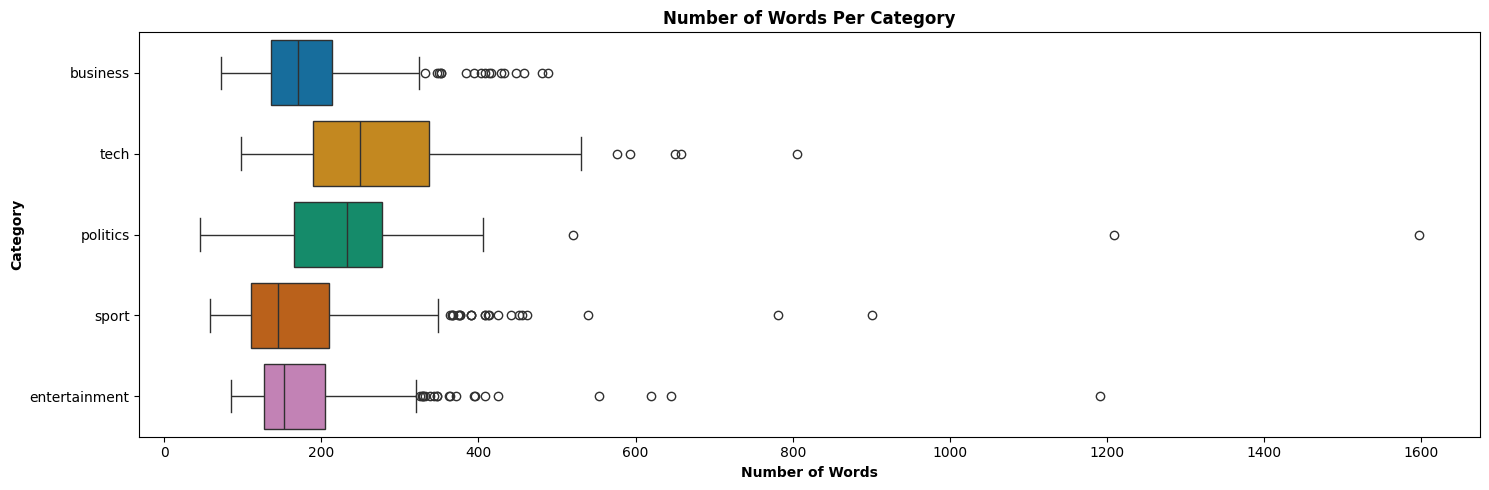

In [37]:
# words per category box plot
plt.figure(figsize=(15, 5))
sns.boxplot(data=df_train,
            x='num_words',
            y='Category',
            hue='Category',
            palette='colorblind')

plt.title('Number of Words Per Category', fontweight='bold')
plt.xlabel('Number of Words', fontweight='bold')
plt.ylabel('Category', fontweight='bold')
plt.tight_layout()
plt.show()

### Visualizing Variances Across Categories

A bar plot of variance by category is used to provide more clarity into the variance. The politics category has the largest variance in article length, while business has the lowest.

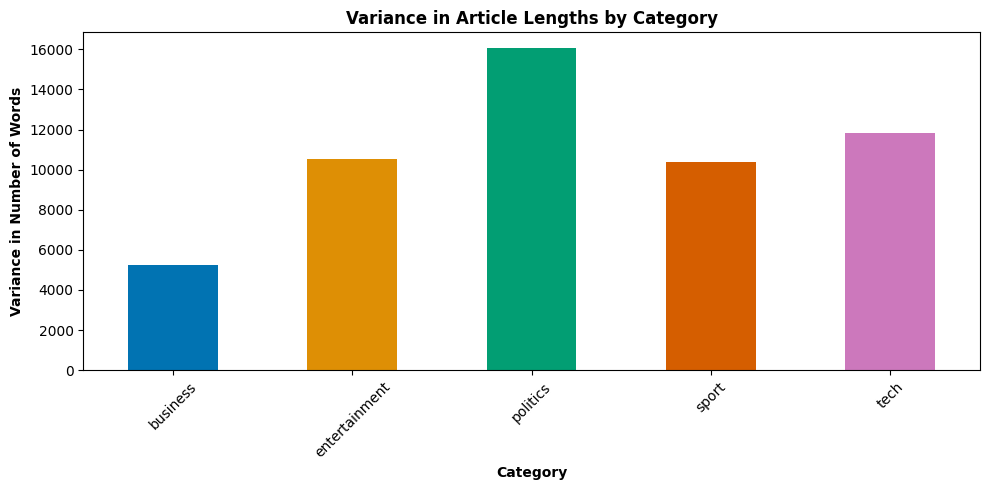

In [41]:
# var of num_words per category
variance_per_category = df_train.groupby('Category')['num_words'].var()

# plotting var as bar plot
variance_per_category.plot(kind='bar', figsize=(10, 5), color=sns.color_palette("colorblind"))
plt.title('Variance in Article Lengths by Category', fontweight='bold')
plt.xlabel('Category', fontweight='bold')
plt.ylabel('Variance in Number of Words', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-------
# Model Building and Training




### Parameter Optimization for Topic Modeling
This code finds the best parameters for TF-IDF vectorization and NMF topic modeling to achieve the highest Adjusted Mutual Information (AMI) score. Since AMI measures how well two clustering results agree while also accounting for random chance, it provides a normalized score between 0 and 1, with 1 being a perfect agreement.

The steps taken to do this atarted with defining the parameter grids for TF-IDF and NMF, specifying which combinations to explore. Then, grid search was applied during which TF-IDF transforms the text data into numerical vectors for each parameter combination. Then, NMF grid search was used, which decomposes the TF-IDF features into topics using each set of parameters. Each combination is scored using AMI, which measures clustering quality compared to the true labels to evaluate performance. The best-performing TF-IDF and NMF parameter combinations are saved for use later in the code.

### Define Parameter Grids:

In [42]:
# define parameter grids for TF-IDF and NMF
tfidf_param_grid = {
    'min_df': [1, 2],
    'max_df': [0.85, 0.95],
    'ngram_range': [(1, 1), (1, 2)],
    'sublinear_tf': [True],
    'norm': ['l2'],
}

nmf_param_grid = {
    'beta_loss': ['frobenius', 'kullback-leibler'],
    'solver': ['mu'],
    'n_components': [1, 5, 10],
    'alpha_W': [0.0],
    'alpha_H': [0.0, 0.1],
    'l1_ratio': [0.0, 0.05],
    'max_iter': [100, 150],
    'init': ['random', 'nndsvda']
}

best_score = -np.inf
best_tfidf_params = None
best_nmf_params = None
best_nmf_model = None

### TF-IDF Grid Search Loop



In [43]:
# perform TF-IDF grid search (part of it)
for tfidf_params in ParameterGrid(tfidf_param_grid):
    tfidf = TfidfVectorizer(stop_words='english', **tfidf_params)

    # IMPORTANT: concatenate train + test texts BEFORE fitting
    full_text = pd.concat([df_train['clean_text'], df_test['clean_text']])
    tfidf_full = tfidf.fit_transform(full_text) # fit_transform on combined text

    # separate out the train portion of tfidf_full
    tfidf_train = tfidf_full[:len(df_train)]

    # don’t transform test portion here, because we only need
    # to measure AMI on the training set for hyperparam search

### NMF Grid Search Loop
nmf_model.fit_transform(tfidf_full) is doing the actual matrix factorization.

TF-IDF Matrix ≈ W_full * H

W_full is the document topic matrix

H is nmf_model.components_, the topic word matrix. It can be extracted after running: W_full = nmf_model.fit_transform(tfidf_full)

In [44]:
# supress ConvergenceWarning for NMF
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# # suppress UserWarning for NMF (e.g., related to init='nndsvd')
# warnings.filterwarnings("ignore", category=UserWarning)

In [45]:
# perform NMF grid search
# use the TF-IDF matrix for train from the previous loop (tfidf_train)
for nmf_params in ParameterGrid(nmf_param_grid):
    nmf_model = NMF(random_state=42, **nmf_params)

    # fit_transform on the entire tfidf_full
    # but, only track AMI on train portion
    W_full = nmf_model.fit_transform(tfidf_full)

    # separate out the training portion
    W_train = W_full[:len(df_train)]

    # predict topics using argmax on train portion
    nmf_train_labels = np.argmax(W_train, axis=1)

    # evaluate AMI on the training set
    score = adjusted_mutual_info_score(df_train['category_id'], nmf_train_labels)

    if score > best_score:
        best_score = score
        best_tfidf_params = tfidf_params
        best_nmf_params = nmf_params
        best_nmf_model = nmf_model

/Users/matthewgraham/anaconda3/envs/google_ml_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
/Users/matthewgraham/anaconda3/envs/google_ml_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
/Users/matthewgraham/anaconda3/envs/google_ml_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
/Users/matthewgraham/anaconda3/envs/google_ml_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
/Users/matthewgraham/anaconda3/envs/google_ml_env/lib/python3.8/site-packages/sklear

Clustering algorithms like NMF assign arbitrary numeric labels to clusters, which do not directly match the true categories in our data. The label_permute function was inspired by a standard approach to label permutation optimization. It optimizes this alignment by evaluating all possible permutations of the cluster labels and selecting the one that maximizes accuracy.

It works by generating permutations to create all possible mappings of cluster labels to the true categories. For each permutation, it maps the cluster labels and calculates the accuracy against the true labels. Lastly, it selects the best mapping by retaining the mapping with the highest accuracy.

In [46]:
# to align cluster labels to categories
def label_permute(ytdf, yp, n=5):
    perms = list(permutations(range(n)))
    best_labels = None
    best_acc = 0
    for perm in perms:
        permuted_labels = [perm[label] for label in yp]
        acc = accuracy_score(ytdf['category_id'], permuted_labels)
        if acc > best_acc:
            best_acc = acc
            best_labels = perm
    return best_labels, best_acc

###  Output Best Results

In [47]:
print("\nBest Results:")
print(f"Best TF-IDF Parameters: {best_tfidf_params}")
print(f"Best NMF Parameters: {best_nmf_params}")
print(f"Best AMI Score: {best_score:.3f}")


Best Results:
Best TF-IDF Parameters: {'max_df': 0.95, 'min_df': 2, 'ngram_range': (1, 2), 'norm': 'l2', 'sublinear_tf': True}
Best NMF Parameters: {'alpha_H': 0.0, 'alpha_W': 0.0, 'beta_loss': 'frobenius', 'init': 'random', 'l1_ratio': 0.0, 'max_iter': 100, 'n_components': 5, 'solver': 'mu'}
Best AMI Score: 0.886


In [48]:
# recreate TF-IDF vectorizer with the best params found
best_tfidf = TfidfVectorizer(stop_words='english', **best_tfidf_params)

# IMPORTANT: again, fit on the combined train+test data
full_text = pd.concat([df_train['clean_text'], df_test['clean_text']])
tfidf_full = best_tfidf.fit_transform(full_text)

# separate the train portion
features = tfidf_full[:len(df_train)]
labels = df_train['category_id']

print("TF-IDF features created with best parameters:")
print(f"Feature matrix shape: {features.shape}")

TF-IDF features created with best parameters:
Feature matrix shape: (1490, 72210)


In [49]:
# use the best NMF model to predict topics for the full data
W_full = best_nmf_model.transform(tfidf_full)

W_train = W_full[:len(df_train)]
nmf_train_labels = np.argmax(W_train, axis=1)

# align NMF labels to true categories (training set)
best_labels, best_acc = label_permute(df_train, nmf_train_labels, n=5)
aligned_labels = [best_labels[label] for label in nmf_train_labels]

print(f"Best accuracy after label alignment: {best_acc:.3f}")

Best accuracy after label alignment: 0.963


### Visualize Results for Unsupervised
t-SNE plots are used for feature visualization, allowing me to understand how well TF-IDF separates categories. The confusion matrix helps me to idenitify patterns in misclassifications. From a quick glance the t-SNE clusters the data well. There are definitely a few that are categorzied wrong. Furthermore, looking at the confusion matrix it is clear that there are some misclassifications in the NMF model.

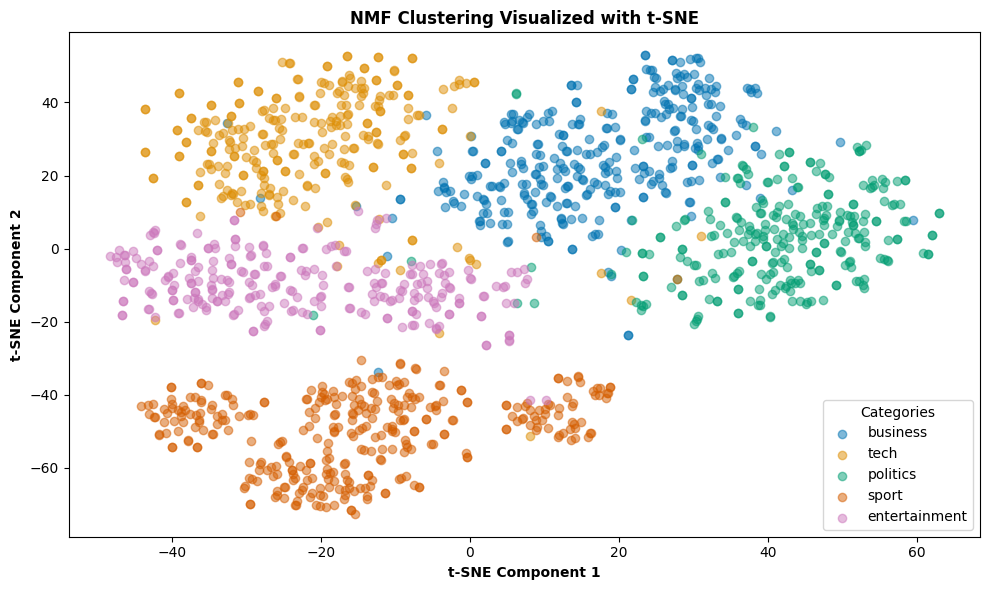

In [51]:
# reduce dimensions for visualization with t-SNE
dense_features = features.toarray()  # convert sparse matrix to dense
projected_features = TSNE(n_components=2, init="random", random_state=42).fit_transform(dense_features)

# plot t-SNE results
plt.figure(figsize=(10, 6))

colors = sns.color_palette("colorblind", n_colors=len(category_to_id))
for category, category_id in category_to_id.items():
    points = projected_features[np.array(aligned_labels) == category_id]
    plt.scatter(points[:, 0], points[:, 1], label=category, alpha=0.5, c=[colors[category_id]])

plt.title("NMF Clustering Visualized with t-SNE", fontweight='bold')
plt.xlabel("t-SNE Component 1", fontweight='bold')
plt.ylabel("t-SNE Component 2", fontweight='bold')
plt.legend(title="Categories")
plt.tight_layout()
plt.show()

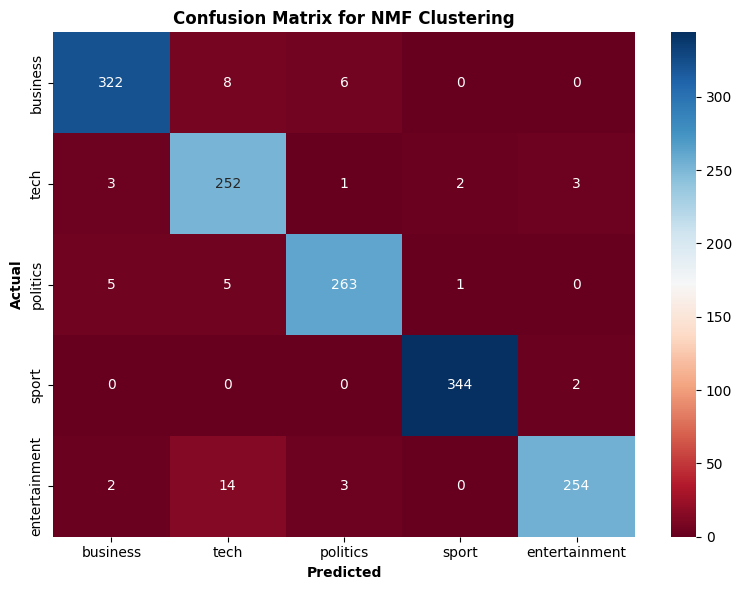

In [56]:
# confusion matrix for aligned labels
conf_mat = confusion_matrix(df_train['category_id'], aligned_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat,
            annot=True,
            fmt='d',
            cmap=sns.color_palette("RdBu", as_cmap=True),
            xticklabels=category_id_df.Category.values,
            yticklabels=category_id_df.Category.values
            )
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.title('Confusion Matrix for NMF Clustering', fontweight='bold')
plt.tight_layout()
plt.show()

### Supervised Classification
This section focuses on training and evaluating supervised classification models on TF-IDF features. Models like Logistic Regression and Multinomial Naive Bayes are trained to predict categories.

In [65]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

models = {'Logistic Regression': LogisticRegression(random_state=42), 'Multinomial Naive Bayes': MultinomialNB()}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{model_name} Accuracy: {accuracy:.3f}")

Logistic Regression Accuracy: 0.983
Multinomial Naive Bayes Accuracy: 0.966


### Visualize Results
t-SNE plots are used for feature visualization, allowing me to understand how well TF-IDF separates categories. The confusion matrix helps me to idenitify patterns in misclassifications. From a quick glance its hard to tell from the t-SNE if the unsupervised model worked better than this multinomialNB. However, looking at the confusion matrix it is clear that there are a lot less misclassifications in the multinomialNB model.

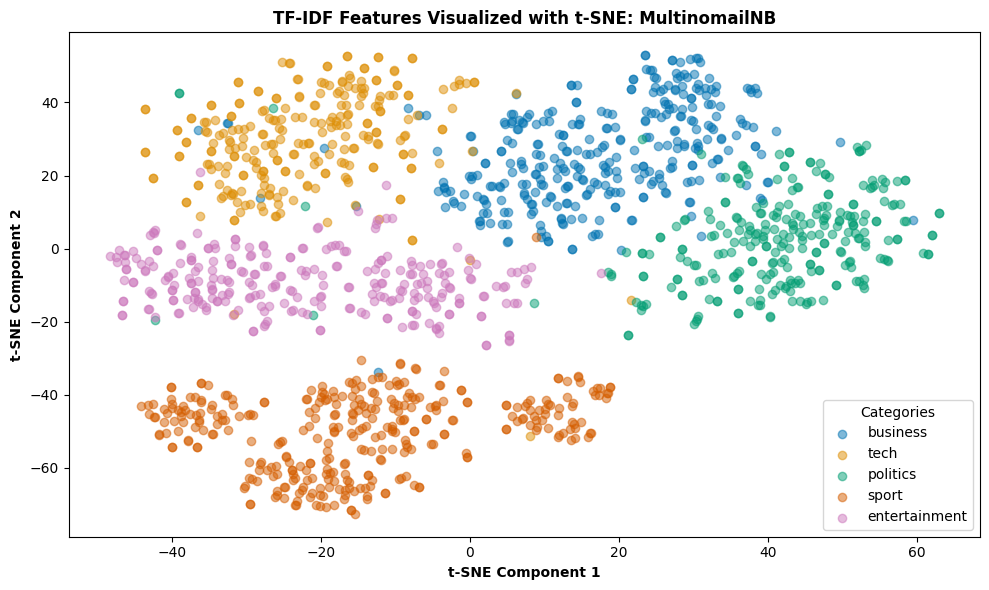

In [66]:
# sparse matrix to dense
dense_features = features.toarray()
projected_features = TSNE(n_components=2, init="random", random_state=42).fit_transform(dense_features)

plt.figure(figsize=(10, 6))
colors = sns.color_palette("colorblind", n_colors=len(category_to_id))
for category, category_id in category_to_id.items():
    points = projected_features[labels == category_id]
    plt.scatter(points[:, 0], points[:, 1], label=category, alpha=0.5, c=[colors[category_id]])

plt.title("TF-IDF Features Visualized with t-SNE: MultinomailNB", fontweight='bold')
plt.legend(title="Categories")
plt.xlabel("t-SNE Component 1", fontweight='bold')
plt.ylabel("t-SNE Component 2", fontweight='bold')
plt.tight_layout()
plt.show()

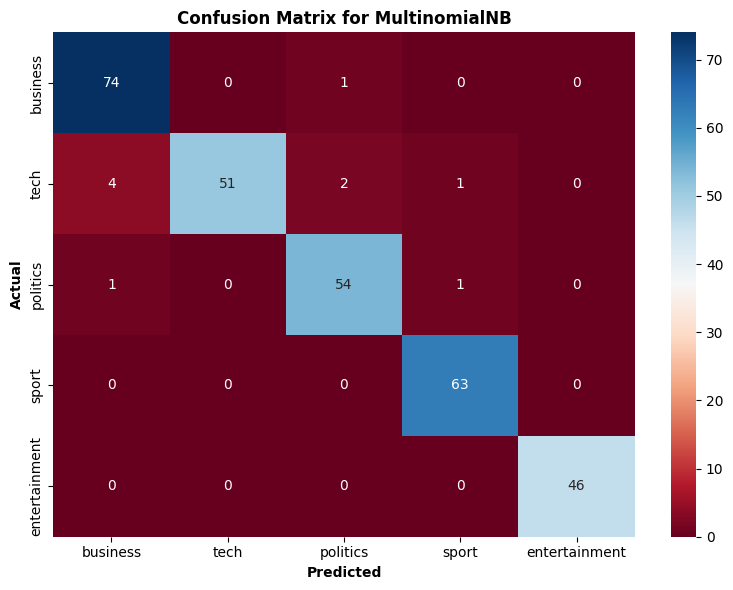

In [67]:
# predict on test set
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat,
            annot=True,
            fmt='d',
            cmap=sns.color_palette("RdBu", as_cmap=True),
            xticklabels=category_id_df.Category.values,
            yticklabels=category_id_df.Category.values
            )
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.title('Confusion Matrix for MultinomialNB', fontweight='bold')
plt.tight_layout()
plt.show()

### Hyperparameter Tuning for Supervised Models
First I will tune model specific parameters to find the best model.

In [68]:
# define param grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [1, 5, 10],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'class_weight': [None, 'balanced']
    },

    'Multinomial Naive Bayes': {
        'alpha': [0.01, 0.1, 0.5, 1, 10],
        'fit_prior': [True, False]
    }
}

### Perform Hyperparameter Tuning with GridSearchCV

In [69]:
# loop thru models and perform GridSearchCV
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grids[model_name],
                               cv=3,
                               n_jobs=-1,
                               scoring='accuracy',
                               verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best CV Accuracy for {model_name}: {grid_search.best_score_:.3f}")

Tuning Logistic Regression...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Accuracy for Logistic Regression: 0.974
Tuning Multinomial Naive Bayes...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Multinomial Naive Bayes: {'alpha': 0.01, 'fit_prior': True}
Best CV Accuracy for Multinomial Naive Bayes: 0.978


### Evaluate Best Models

In [70]:
# eval best versions of the models on the test set
print("Evaluating Best Models on Test Set:")
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.3f}")

Evaluating Best Models on Test Set:
Logistic Regression Test Accuracy: 0.987
Multinomial Naive Bayes Test Accuracy: 0.980


Logistic Regression slightly outperformed Multinomial Naive Bayes.

 Split Raw Text Data to ensure there is no data leakage. I need to make sure that the information from the test set does not influence the training. Since I transform the entire dataset into TF-IDF features before it is split, TfidfVectorizer will know the test data while fitting on the full dataset, which infaltes the accuracy.

In [71]:
# split raw text data (not the TF-IDF features)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_train['clean_text'], # use raw text column
                                                            df_train['category_id'],
                                                            test_size=0.2,
                                                            random_state=42)

### Define Pipeline and Parameter Grid

In [72]:
# define pipeline
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), ('model', MultinomialNB())])

# define param grid for TF-IDF and MultinomialNB
param_grid = {
    'tfidf__min_df': [1, 2, 5], # min document frequency
    'tfidf__max_df': [0.85, 0.9, 0.95], # max document frequency
    'tfidf__ngram_range': [(1, 1), (1, 2)], # unigrams and bigrams
    'model__alpha': [0.05, 0.1, 0.25] # smoothing parameter
}

### Perform Grid Search

In [73]:
print("Starting Grid Search...")
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1)

grid_search.fit(X_train_raw, y_train) # raw text data
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.3f}")

Starting Grid Search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'model__alpha': 0.05, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best CV Accuracy: 0.977


### Use the Best Pipeline

In [74]:
# use best pipeline
best_pipeline = grid_search.best_estimator_

# eval on the test set
test_accuracy = best_pipeline.score(X_test_raw, y_test)
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.980


### Model Interpretation


 Extract Model and TF-IDF Vectorizer

In [75]:
print(best_pipeline.named_steps['model'])
model = best_pipeline.named_steps['model']  
tfidf = best_pipeline.named_steps['tfidf']  

MultinomialNB(alpha=0.05)


### Define Function to Get Top Features

 This functiong gets the top N features for a given category.

In [76]:
def get_top_features_nb(model, feature_names, category_id, N=5):
    log_probs = model.feature_log_prob_[category_id]
    # sort features by log probabilities
    indices = np.argsort(log_probs)[-N:] 
    top_features = feature_names[indices] # map indices to feature names
    return top_features

### Extract and Print Top Features for Each Category

In [77]:
# get feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()
N = 5 

# show top features for each category
for category, category_id in category_to_id.items():
    top_features = get_top_features_nb(model, feature_names, category_id, N=N)
    print(f"Top features for {category}: {', '.join(top_features)}")

Top features for business: year, bank, company, firm, bn
Top features for tech: game, technology, people, phone, mobile
Top features for politics: party, blair, election, labour, mr
Top features for sport: match, win, player, england, game
Top features for entertainment: star, actor, best, award, film


_______
# Model Comparisons

For this project, I need to use unsupervised learning to classify text articles uing matrix factorization model. Usually, supervised models would perform better with this type of data since we have pre labeled text data. So, I will compare the best unsupervised learning model to our best supervised model below.

 Reload and Preprocess Data

In [78]:
# reload train and test data
train = pd.read_csv("../data/BBC News Train.csv")
test = pd.read_csv("../data/BBC News Test.csv")

# add category-to-ID mapping for training data
train['category_id'] = train['Category'].factorize()[0]
category_id_df = train[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

train = text_cleaning(train, 'Text')
test = text_cleaning(test, 'Text')

Train NMF Model and Generate Unsupervised Predictions

In [81]:
# concatenate train and test texts so that TF-IDF (and NMF) see all words from both sets
combined_df = pd.concat([train, test], axis=0, ignore_index=True)

# TF-IDF vectorizer w optimal parameters
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, norm='l2', ngram_range=(1, 2), stop_words='english', sublinear_tf=True)

tfidf_full = tfidf.fit_transform(combined_df['clean_text'])

nmf_model = NMF(n_components=5, alpha_W=0.0, beta_loss='frobenius', l1_ratio=0.0, max_iter=100, random_state=42)

W_full = nmf_model.fit_transform(tfidf_full)

# separate the NMF output into train & test slices
#  first len(train) rows correspond to train
#  remaining rows correspond to test
num_train = len(train)
W_train = W_full[:num_train]
W_test  = W_full[num_train:]

# assign cluster labels
nmf_train_labels = np.argmax(W_train, axis=1)
nmf_test_labels = np.argmax(W_test, axis=1)

# use label_permute to align cluster indices to actual category IDs for the training set.
train_labels_df = train[['category_id']].copy()
best_mapping, train_accuracy = label_permute(train_labels_df, nmf_train_labels, n=5)
print(f"Best Label Mapping: {best_mapping}")
print(f"Training Accuracy after Mapping: {train_accuracy:.3f}")

mapped_test_labels = [best_mapping[label] for label in nmf_test_labels]

# map final integer label -> category names
test['Predicted_Category_NMF'] = [id_to_category[label] for label in mapped_test_labels]

submission_unsupervised = pd.DataFrame({'ArticleId': test['ArticleId'], 'Category': test['Predicted_Category_NMF']})
submission_unsupervised.to_csv('submission_unsupervised.csv', index=False)

print("Unsupervised submission file created successfully!")
print(test['Predicted_Category_NMF'].value_counts())

Best Label Mapping: (0, 3, 2, 1, 4)
Training Accuracy after Mapping: 0.954
Unsupervised submission file created successfully!
Predicted_Category_NMF
sport            167
business         163
tech             155
politics         149
entertainment    101
Name: count, dtype: int64


 Cross-Validation for NMF Model

In [82]:
# initialize cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, val_index in kf.split(train['clean_text'], train['category_id']):
    X_train, X_val = train.iloc[train_index]['clean_text'], train.iloc[val_index]['clean_text']
    y_train, y_val = train.iloc[train_index]['category_id'], train.iloc[val_index]['category_id']

    # create TF-IDF vectorizer
    tfidf = TfidfVectorizer(min_df=2, max_df=0.95, norm='l2', ngram_range=(1, 2), stop_words='english', sublinear_tf=True)

    tfidf_train = tfidf.fit_transform(X_train)
    tfidf_val = tfidf.transform(X_val)

    # train NMF model
    nmf_model = NMF(n_components=5, alpha_W=0.0, beta_loss='frobenius', l1_ratio=0.0, max_iter=100, random_state=42)
    W_train = nmf_model.fit_transform(tfidf_train)
    W_val = nmf_model.transform(tfidf_val)
    nmf_train_labels = np.argmax(W_train, axis=1)
    train_labels_df = pd.DataFrame({'category_id': y_train.values})
    best_mapping, _ = label_permute(train_labels_df, nmf_train_labels)

    # predict topics on validation data
    nmf_val_labels = np.argmax(W_val, axis=1)
    mapped_val_labels = [best_mapping[label] for label in nmf_val_labels]

    val_accuracy = accuracy_score(y_val, mapped_val_labels)
    cv_scores.append(val_accuracy)

# calc and print mean cross validation accuracy
mean_cv_accuracy = np.mean(cv_scores)
print(f"Cross-Validation Accuracy: {mean_cv_accuracy:.3f}")

Cross-Validation Accuracy: 0.952


The two accuracies being close with Training Accuracy: 0.956 and Cross-Validation Accuracy: 0.952 is a good sign that this model generalizes well. The small gap between training and validation scores means that the model is not overfitting to the training data. The learned latent features likely captures meaningful patterns in the data that extend tothe unseen data.

In [83]:
# check words in each category
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx}: {[tfidf.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]}")

Topic 0: ['people', 'user', 'technology', 'phone', 'mobile', 'service', 'software', 'digital', 'computer', 'use']
Topic 1: ['game', 'win', 'england', 'player', 'cup', 'match', 'team', 'champion', 'play', 'said']
Topic 2: ['mr', 'election', 'labour', 'party', 'blair', 'tory', 'minister', 'government', 'prime minister', 'prime']
Topic 3: ['film', 'award', 'actor', 'best', 'star', 'oscar', 'actress', 'director', 'nomination', 'movie']
Topic 4: ['bn', 'growth', 'market', 'said', 'company', 'firm', 'year', 'economy', 'share', 'price']


We can see above that the words associated with each topic make sense. Words like technology, phone, and mobile align with tech. Game, win, and player also make sense for the sports category. Similarly, election, party, and government clearly go into the politics category. Film, actor, and oscar from topic 3 are also definitely from the entertainment category. Lastly, market, firm, and economy also make sense for the business category.

Supervised Learning: Use the best pipeline from above to predict test labels

In [84]:
# predict categories for test set using the best pipeline
test_predictions = best_pipeline.predict(test['clean_text'])

# map predicted category IDs to category names
test['Predicted_Category_Supervised'] = [id_to_category[label] for label in test_predictions]

In [85]:
# submission file for supervised model
submission_supervised = pd.DataFrame({'ArticleId': test['ArticleId'], 'Category': test['Predicted_Category_Supervised']})

submission_supervised.to_csv('submission_supervised.csv', index=False)
print("Supervised submission file created successfully")

Supervised submission file created successfully


### Supervised Model Test Accuracy from Kaggle Submission: 0.97687

### Unsupervised Model Test Accuracy from Kaggle Submission: 0.95102


# Further Enhancements with BERT

I wanted to experiment with using BERT (Bidirectional Encoder Representations from Transformers) for the BBC News classification project. BERT can capture contextual meaning from both the left and right sides of a word at the same time, unlike the earlier models that processed text in a strictly left-to-right or right-to-left manner. This bidirectional understanding makes BERT particularly powerful for short-text and long-text classification tasks alike.

By fine tuning a pretrained BERT model on our BBC dataset, I leveraged the rich language patterns that BERT learned from massive amounts of general-domain text. Consequently, BERT achieved the highest accuracy in my first Kaggle submission with it—98.775%. It surpassed all other approaches I tried, including classical ML models with TF-IDF features.

Key Learnings:

- Contextual Embeddings: BERT’s ability to interpret words in context significantly boosts classification performance.

- Fine-Tuning: Adapting BERT to a specific task requires only adding a small classification head on top, then training on the labeled data.

- Practical Implementation: While BERT can be computationally heavier, tools like Hugging Face Transformers simplify the process with pre-built tokenizers, model APIs, and trainers.


Overall, experimenting with BERT has deepened my understanding of Transformer-based architectures and reinforced the importance of modern NLP techniques for achieving cutting edge results in text classification.

### Importing Libraries

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from evaluate import load

In [87]:
train = pd.read_csv("../data/BBC News Train.csv")
test = pd.read_csv("../data/BBC News Test.csv")

# map Category to category_id
train['category_id'] = train['Category'].factorize()[0]
category_id_df = train[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

# for BERT rename cols s.t. HF sees text and label -> label must be numeric
train = train.rename(columns={'Text': 'text', 'category_id': 'label'})
test = test.rename(columns={'Text': 'text'}) # test doesn't have a label


In [88]:
# pandas df to HF Datasets
train_dataset = Dataset.from_pandas(train) # cols: [Category, text, label, ...]
test_dataset = Dataset.from_pandas(test) # cols: [Category, text, ...] (no label)

### Tokenization
Map the tokenization function over each data set s.t. each row is tokenized into input_ids, attention_mask, ...

In [ ]:
# model_name = "bert-base-uncased"
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)


### Prepare Model
Load BERT for classification with the correct number of output labels.

In [ ]:
num_labels = len(category_id_df)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


### Train/Validation Split & TrainingArguments


In [ ]:
# 80/20 split from the train_tokenized for internal validation
train_val = train_tokenized.train_test_split(test_size=0.2, seed=42)
train_split = train_val["train"]
val_split = train_val["test"]

training_args = TrainingArguments(
    output_dir="./bert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
)


### Trainer and Fine-Tune
Fine-tune BERT on the training split, evaluate on validation each epoch, and keep track of the best model by accuracy.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_split,
    eval_dataset=val_split,
    tokenizer=tokenizer,      
    compute_metrics=compute_metrics
)

trainer.train()

### Evaluate and Predict
test_pred_labels are numeric, so map them back to original category names with id_to_category. Then, write out a CSV to submit to Kaggle.

In [ ]:
# eval on val set (already done each epoch, but do a final check):
final_val_metrics = trainer.evaluate(val_split)
print("Final validation metrics:", final_val_metrics)

# predict on actual Kaggle test data
test_predictions = trainer.predict(test_tokenized)
test_pred_labels = np.argmax(test_predictions.predictions, axis=-1)

# change numeric labels to Category strings
test["Predicted_Category"] = [id_to_category[label] for label in test_pred_labels]

submission = pd.DataFrame({ "ArticleId": test["ArticleId"], "Category": test["Predicted_Category"]})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


Final validation metrics: {'eval_loss': 0.10666494071483612, 'eval_accuracy': 0.9765100671140939, 'eval_runtime': 1.2246, 'eval_samples_per_second': 243.347, 'eval_steps_per_second': 15.515, 'epoch': 3.0}
Submission file saved as submission.csv


### Cross-Validation
I used scikit-learn’s StratifiedKFold on the training data. For each fold, I split the training data into (train_fold, val_fold). Then, I converted to HF datasets and tokenized. I made a new AutoModelForSequenceClassification and Trainer. Then, I trained for a few epochs and evaluated on that fold’s validation portion. I stored the accuracy, then averaged across folds.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracies = []

# convert entire train df into HF Dataset again (or reuse train_dataset)
full_dataset = Dataset.from_pandas(train)  

def tokenize_function_cv(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

for fold, (train_idx, val_idx) in enumerate(skf.split(train['text'], train['label'])):
    print(f"\n***** Starting fold {fold+1}/{5} *****")

    # subset data for this fold, subset, and tokenize 
    train_fold_df = train.iloc[train_idx].reset_index(drop=True)
    val_fold_df   = train.iloc[val_idx].reset_index(drop=True)
    train_fold_ds = Dataset.from_pandas(train_fold_df).map(tokenize_function_cv, batched=True)
    val_fold_ds   = Dataset.from_pandas(val_fold_df).map(tokenize_function_cv, batched=True)

    # fresh model for each fold
    fold_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    fold_training_args = TrainingArguments(
        output_dir=f"./roberta_fold_{fold}",
        evaluation_strategy="epoch",
        save_strategy="no", # won't save checkpoints each epoch to save time
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        logging_dir=f"./logs_fold_{fold}",
        logging_steps=50,
        load_best_model_at_end=False,
        metric_for_best_model="accuracy",
    )

    # create Trainer
    fold_trainer = Trainer(
        model=fold_model,
        args=fold_training_args,
        train_dataset=train_fold_ds,
        eval_dataset=val_fold_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    fold_trainer.train()

    result = fold_trainer.evaluate(val_fold_ds)
    acc = result["eval_accuracy"]
    all_accuracies.append(acc)

    print(f"Fold {fold+1} accuracy:", acc)

# after all folds
mean_cv_acc = np.mean(all_accuracies)
print(f"\n***** Mean 5-Fold CV Accuracy: {mean_cv_acc:.4f} *****")


Since cross-validation trained on 80% of the data, it left out 20% for validation in that fold.
Now that I see the average cross-validation accuracy (~98.46%), I will retrain on all (100%) of the training data with the same hyperparameters. This final model is what I will use for inference on the test set (because it has seen the maximum possible labeled data and presumably generalizes best).


### Final Training with All Data

In [ ]:
#convert the entire train DataFrame to a HF Dataset
full_dataset = Dataset.from_pandas(train)

# tokenize full dataset
def tokenize_function_full(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_full = full_dataset.map(tokenize_function_full, batched=True)

# new model using same hyperparams discovered w CV
final_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# define training arguments
final_training_args = TrainingArguments(
    output_dir="./roberta_optimized_final",
    evaluation_strategy="no",   
    save_strategy="no",         
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_dir="./logs_final",
    logging_steps=50,
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",
)

# create final Trainer
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=tokenized_full, # all training data
    tokenizer=tokenizer,
)

# train on ALL train data
final_trainer.train()


### Predict on Test now and create submission file

In [ ]:
# already have test_dataset, so just re-tokenize if needed
test_dataset = Dataset.from_pandas(test)

def tokenize_function_test(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

test_tokenized = test_dataset.map(tokenize_function_test, batched=True)

predictions = final_trainer.predict(test_tokenized)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# convert numeric labels to Category names
test["Predicted_Category"] = [id_to_category[label] for label in pred_labels]

# create submission
submission_BERT_optimized = pd.DataFrame({"ArticleId": test["ArticleId"], "Category": test["Predicted_Category"]})
submission_BERT_optimized.to_csv("submission_BERT_optimized.csv", index=False)
print("Final submission file saved as submission_BERT_optimized.csv")


# BERT: roberta-base test accuracy from Kaggle submission: 0.98775


# Citations

Brown, Jordan. (2024, December 12). A comprehensive guide to text pre-processing for natural language processing. Retrieved from https://www.33rdsquare.com/essential-text-pre-processing-techniques-for-nlp/


Brown, Jordan. (2024, December 30). A step-by-step guide to implementing BERT for natural language processing. 33rd Square. Retrieved from https://www.33rdsquare.com/step-by-step-bert-implementation-guide/

Brown, Jordan. (2024, December 9). Why and how to use BERT for NLP text classification. 33rd Square. Retrieved from https://www.33rdsquare.com/why-and-how-to-use-bert-for-nlp-text-classification/

GeeksforGeeks. (2024, October 3). Text preprocessing for NLP tasks. Retrieved from https://www.geeksforgeeks.org/text-preprocessing-for-nlp-tasks/

GeeksforGeeks. (2022, February 21). NLP - Expand contractions in text processing. Retrieved from https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/

Harini, M. (2024, August 27). Text preprocessing techniques in NLP: Tokenization, lemmatization, and stemming. Retrieved from https://www.goml.io/text-preprocessing-techniques-in-nlptokenization-lemmatization-and-stemming/


Muller, Britney. (2022, March 2). BERT 101: State-of-the-art NLP model explained. Hugging Face. Retrieved from https://huggingface.co/blog/bert-101


Sreemany, Tithi. (2024, October 16). Essential text pre-processing techniques for NLP!. Retrieved from https://www.analyticsvidhya.com/blog/2021/09 essential-text-pre-processing-techniques-for-nlp/





